# Transpiling Quantum Circuits

In this chapter we will investigate how quantum circuits are transformed when run on quantum devices.  That we need to modify the circuits at all is a consequence of the limitations of current quantum computing hardware.  Namely, the limited connectivity inherent in most quantum hardware, restricted gate sets, as well as environmental noise and gate errors, all conspire to limit the effective computational power on today's quantum devices.  Fortunately, quantum circuit rewriting tool chains have been developed that directly address these issues, and return heavily optimized circuits mapped to targeted quantum devices.  Here we will explore the IBM Qiskit 'transpiler' circuit rewriting framework.

In [1]:
import numpy as np
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.providers.ibmq import least_busy
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

## Core Steps in Circuit Rewriting

As we will see, rewriting quantum circuits to match hardware constraints and optimize for performance can be far from trivial.  The flow of logic in the rewriting tool chain need not be linear, and can often have iterative sub-loops, conditional branches, and other complex behaviors.  That being said, the basic building blocks follow the structure given below.

![image1](images/transpiling_core_steps.png)


Our goal in this section is to see what each of these "passes" does at a high-level, and then begin exploring their usage on a set of common circuits.

### Unrolling to Basis Gates

When writing a quantum circuit you are free to use any quantum gate (unitary operator) that you like, along with a collection of non-gate operations such as qubit measurements and reset operations.  However, when running a circuit on a real quantum device one no longer has this flexibility.  Due to limitations in, for example, the physical interactions between qubits, difficulty in implementing multi-qubit gates, control electronics etc, a quantum computing device can only natively support a handful of quantum gates and non-gate operations. In the present case of IBM Q devices, the native gate set can be found by querying the devices themselves:

In [3]:
provider = IBMQ.get_provider(group='open')
provider.backends(simulator=False)

[<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [4]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 5 and not x.configuration().simulator and x.status().operational==True))
backend.configuration().basis_gates

['id', 'u1', 'u2', 'u3', 'cx']

We see that the our device supports five native gates: three single-qubit gates (`u1`, `u2`, `u3`, and `id`) and one two-qubit entangling gate `cx`.  In addition, the device supports qubit measurements (otherwise we can not read out an answer!).  Although we have queried only a single device, all IBM Q devices support this gate set.

The `u*` gates represent arbitrary single-qubit rotations of one, two, and three angles.  The `u1` gates are single-parameter rotations that represent generalized phase gates of the form

$$
U_{1}(\lambda) = \begin{bmatrix}
1 & 0 \\
0 & e^{i\lambda}
\end{bmatrix}
$$

This set includes common gates such as $Z$, $T$, $T^{\dagger}$, $S$, and $S^{\dagger}$.  It turns out that these gates do not actually need to be performed on hardware, but instead, can be implemented in software as "virtual gates".  These virtual gates are called "frame changes" and take zero time, and have no associated error; they are free gates on hardware.

Two-angle rotations, $U_{2}(\phi,\lambda)$, are actually two frame changes with a single $X_{\pi/2}$ gate in between them, and can be used to synthesize gates like the Hadamard ($U_{2}(0,\pi)$) gate.  As the only actual gate performed is the $X_{\pi/2}$ gate, the error and gate time associated with any $U_{2}$ gate is the same as an $X_{\pi/2}$ gate.  Similarly, $U_{3}(\theta,\phi,\lambda)$ gates are formed from three frame changes with two $X_{\pi/2}$ gates in between them.  The errors and gate times are twice those of a single $X_{\pi/2}$.  The identity gate, $id$, is straightforward, and is a placeholder gate with a fixed time-interval. 

The only entangling gate supported by the IBM Q devices is the CNOT gate (`cx`) that, in the computational basis, can be written as:

$$
\mathrm{CNOT}(0,1) = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}
$$,

where we see that the matrix form follows from the specific bit-ordering convention used in Qiskit.

Every quantum circuit run on a IBM Q device must be expressed using only these basis gates.  For example, suppose one wants to run a simple phase estimation circuit:

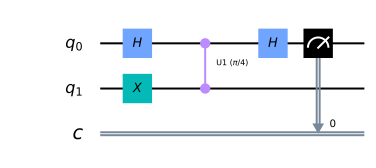

In [5]:
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(1, 'c')
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.x(qr[1])
qc.cp(np.pi/4, qr[0], qr[1])
qc.h(qr[0])
qc.measure(qr[0], cr[0])
qc.draw()

We have $H$, $X$, and controlled-$U_{1}$ gates, all of which are not in our devices basis gate set, and must be expanded.  We will see that this expansion is taken care of for you, but for now let us just rewrite the circuit in the basis gate set:

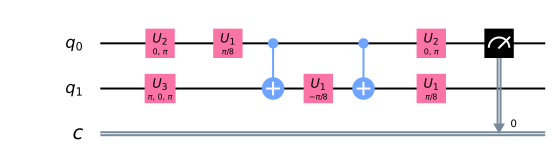

In [6]:
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(1, 'c')
qc_basis = QuantumCircuit(qr, cr)

# Hadamard in U2 format
qc_basis.u2(0, np.pi, qr[0])
# X gate in U3 format
qc_basis.u3(np.pi, 0, np.pi, qr[1])

# Decomposition for controlled-phase with lambda=pi/4
qc_basis.p(np.pi/8, qr[0]) 
qc_basis.cx(qr[0], qr[1]) 
qc_basis.p(-np.pi/8, qr[1]) 
qc_basis.cx(qr[0], qr[1])
qc_basis.p(np.pi/8, qr[1])

# Hadamard in U2 format
qc_basis.u2(0, np.pi, qr[0]) 

qc_basis.measure(qr[0], cr[0])
qc_basis.draw()

A few things to highlight.  One, the circuit has gotten longer with respect to the initial one.  This can be verified by checking the depth of the circuits:

In [7]:
print(qc.depth(), ',', qc_basis.depth())

4 , 7


Second, although we had a single controlled gate, the fact that it was not in the basis set means that, when expanded, it requires more than a single `cx` gate to implement. All said, unrolling to the basis set of gates leads to an increase in the length of a quantum circuit and the number of gates.  Both of these increases lead to more errors from the environment and gate errors, respectively, and further circuit rewriting steps must try to mitigate this effect through circuit optimizations.

Finally, we will look at the particularly important example of a Toffoli, or controlled-controlled-not gate:

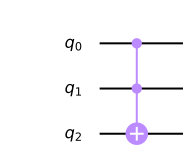

In [8]:
qr = QuantumRegister(3, 'q')
qc = QuantumCircuit(qr)

qc.ccx(qr[0], qr[1], qr[2])
qc.draw(output='mpl')

As a three-qubit gate, it should already be clear that this is not in the basis set of our devices.  We have already seen that controlled gates not in the basis set are typically decomposed into multiple CNOT gates.  This is doubly true for controlled gates with more than two qubits, where multiple CNOT gates are needed to implement the entangling across the multiple qubits.  In our basis set, the Toffoli gate can be written as:

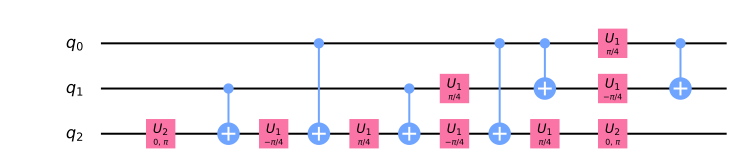

In [9]:
qr = QuantumRegister(3, 'q')
qc_basis = QuantumCircuit(qr)

qc_basis.u2(0,np.pi, qr[2])
qc_basis.cx(qr[1], qr[2])
qc_basis.p(-np.pi/4, qr[2])
qc_basis.cx(qr[0], qr[2])
qc_basis.p(np.pi/4, qr[2])
qc_basis.cx(qr[1], qr[2])
qc_basis.p(np.pi/4, qr[1])
qc_basis.p(-np.pi/4, qr[2])
qc_basis.cx(qr[0], qr[2])
qc_basis.cx(qr[0], qr[1])
qc_basis.p(np.pi/4, qr[2])
qc_basis.p(np.pi/4, qr[0])
qc_basis.p(-np.pi/4, qr[1])
qc_basis.u2(0,np.pi, qr[2])
qc_basis.cx(qr[0], qr[1])
qc_basis.draw()

Therefore, for every Toffoli gate in a quantum circuit, the IBM Q hardware must execute six CNOT gates, and a handful of single-qubit gates.  From this example, it should be clear that any algorithm that makes use of multiple Toffoli gates will end up as a circuit with large depth and with therefore be appreciably affected by noise and gate errors.

### Initial Layout

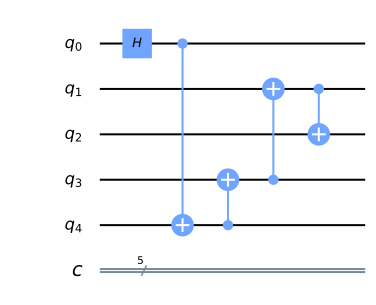

In [10]:
qr = QuantumRegister(5, 'q')
cr = ClassicalRegister(5, 'c')
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.cx(qr[0], qr[4])
qc.cx(qr[4], qr[3])
qc.cx(qr[3], qr[1])
qc.cx(qr[1], qr[2])

qc.draw(output='mpl')

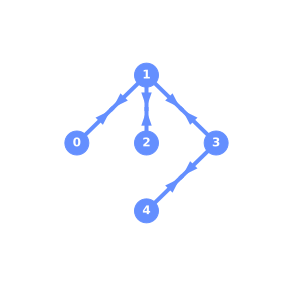

In [11]:
from qiskit.visualization.gate_map import plot_gate_map
plot_gate_map(backend, plot_directed=True)

In [12]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}